In [1]:
using Pkg
Pkg.activate("../..")

  Activating project at `c:\Users\ladis\GitHub\SparseSpikes`


In [2]:
using Plots, LinearAlgebra, Random
using SparseSpikes


SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


1D

In [3]:
domain  = [0, 1]

2-element Vector{Int64}:
 0
 1

In [276]:
n_coarse_grid = 20
n_plt_grid = 1000

coarse_grid = build_grid(domain, n_coarse_grid)
plt_grid = build_grid(domain, n_plt_grid)

plot_size = (400, 250) .* 2
plt = plot(xlims=extrema(domain), ylims=(-3, 3), size=plot_size, legend=:none)
hline!(plt, [0], linestyle=:solid, color=:black);

In [446]:
ops = gaussian_operators_1D(0.06, coarse_grid);

## Pre-certificate

1.0000024122539408

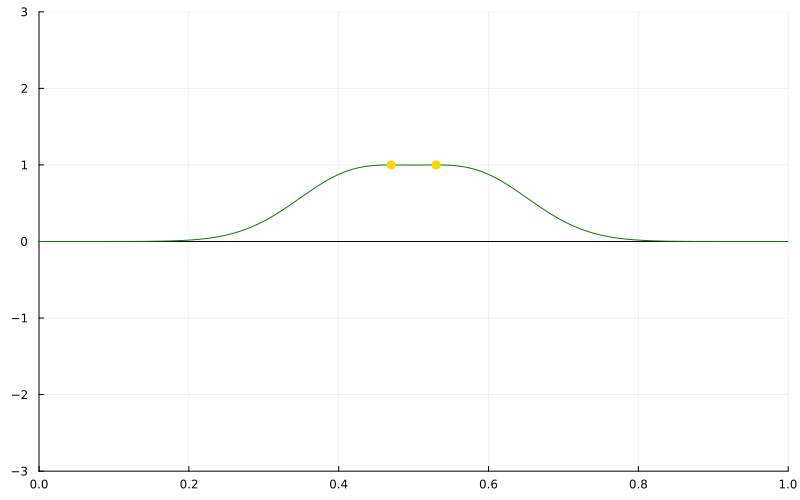

In [447]:
# Easy case
# x₀ = [0.2, 0.8]
# a₀ = [1.0, -1.0]

# Slightly harder case
# x₀ = [0.21, 0.44, 0.63, 0.82]
# a₀ = [0.91, -0.78, 0.56, -0.86]

# Close positive spikes
x₀ = [0.47, 0.53]
a₀ = [1.0, 1.0]

# Degenerate case
# x₀ = [0.41, 0.59]
# a₀ = [1.0, -1.0]

# 9 spikes
# x₀ = [0.143, 0.197, 0.247, 0.391, 0.479, 0.633, 0.797, 0.939, 0.990]
# a₀ = [0.779, 0.543, 0.623, -0.580, 0.699, 0.422, 0.431, -0.274, -0.086]

μ₀ = DiscreteMeasure(x₀, a₀)

ηᵥ = ops.ηᵥ(μ₀...)
display(maximum(abs.(ηᵥ(plt_grid))))

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηᵥ(plt_grid), color=:green)
plot_spikes!(plt_cert, μ₀, color=:gold)

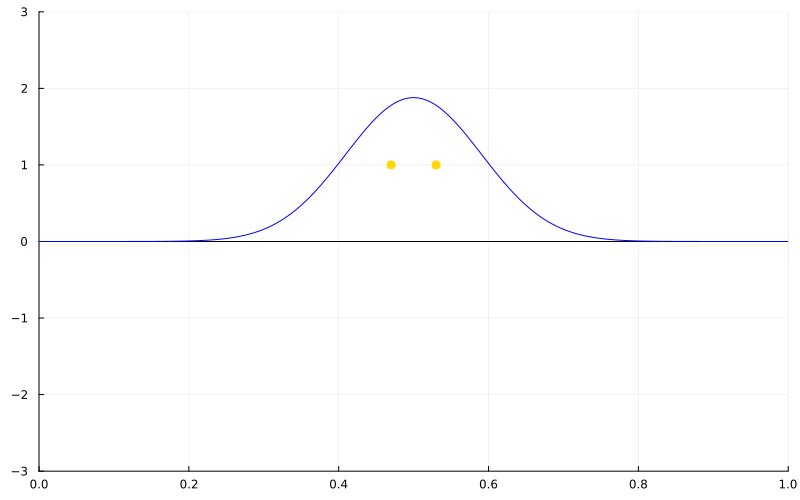

In [448]:
y₀ = ops.Φₓ(μ₀...)

function add_noise(y₀, δ)
    ϵ  = randn(length(y₀))
    ϵ = ϵ / norm(ϵ) * δ
    y = y₀ + ϵ
    return y
end

# Add noise to the observation y = y₀ + ϵ
noise_level = 0.0
Random.seed!(16)
δ = noise_level * norm(y₀)
y = add_noise(y₀, δ)

τδ = norm(ops.Φₓ(μ₀...) - y) + max(5e-2, δ)

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.Φₓᴴ(y, grid=plt_grid), color=:blue)
plot_spikes!(plt_obs, μ₀, color=:gold)

Run SFW once to compile functions.

0.1

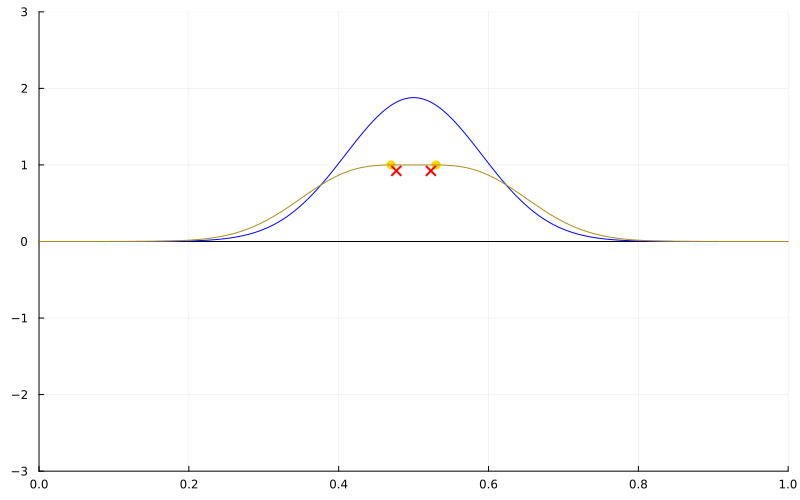

In [449]:
plt_SFW = deepcopy(plt_obs)

prob_SFW = BLASSO(y, ops, domain, n_coarse_grid, λ=0.1)
solve!(prob_SFW, :SFW, options=Dict(:verbose => false, :maxits => 10))
display(prob_SFW.λ)
plot_spikes!(plt_SFW, prob_SFW.μ, color=:red, marker=:x, markerstrokewidth=2)
plot!(plt_grid, prob_SFW.η(plt_grid))

0.03983409288023134

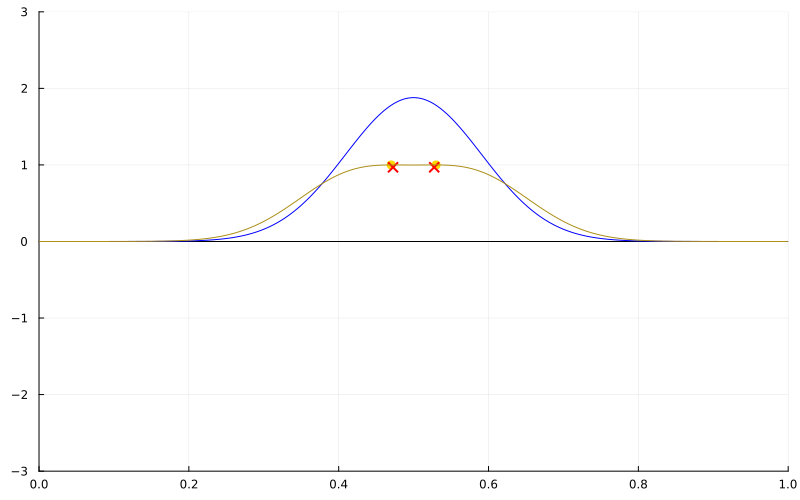

In [450]:
plt_MDP = deepcopy(plt_obs)

prob_MDP = BLASSO(y, ops, domain, n_coarse_grid)
solve!(prob_MDP, :MDP, options=Dict(:verbose => false, :maxits => 600, :inner_maxits => 15, :store_reg_path => true, :τδ => τδ, :q => 0.99, :η_tol => 1e-5, :warm_start => false))
display(prob_MDP.λ)
plot_spikes!(plt_MDP, prob_MDP.μ, color=:red, marker=:x, markerstrokewidth=2)
plot!(plt_grid, prob_MDP.η(plt_grid))

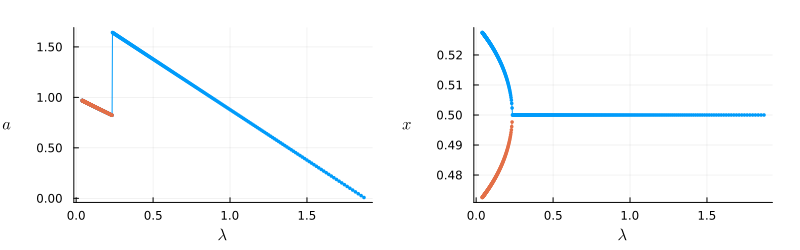

In [451]:
λs, μs = values(prob_MDP.reg_path)
x_paths, a_paths = build_reg_paths(λs, μs, C=1e10)
plt_MDP_paths = plot_reg_paths(λs, x_paths, a_paths, size=(800, 250))

"NODE! completed with 130 corrections over 1952 iterations."

0.024012480960401136

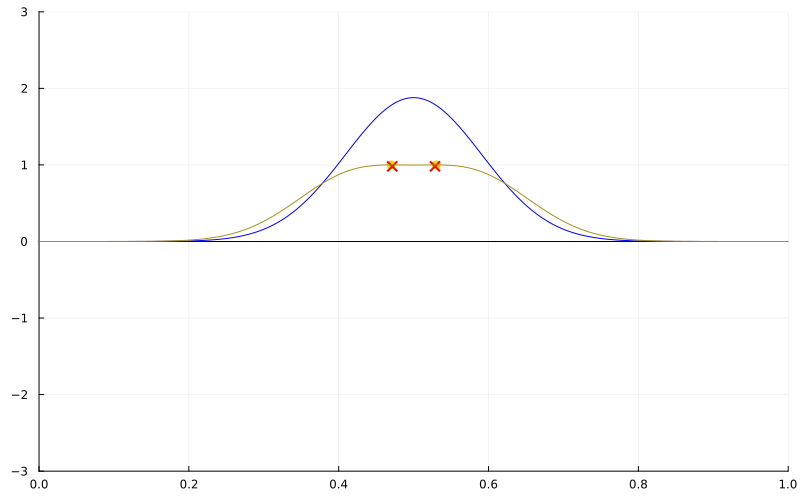

In [ ]:
plt_NODE = deepcopy(plt_obs)

prob_NODE = BLASSO(y, ops, domain, n_coarse_grid)
solve!(prob_NODE, :NODE, options=Dict(:verbose => false, :store_reg_path => true, :maxits => 10000, :τδ => 0.6τδ, :h => 1e-4, :η_tol => 1e-4, :inner_maxits => 15))
display(prob_NODE.λ)
plt_NODE = deepcopy(plt_obs)
plot_spikes!(plt_NODE, prob_NODE.μ, color=:red, marker=:x, markerstrokewidth=2)
plot!(plt_grid, prob_NODE.η(plt_grid))

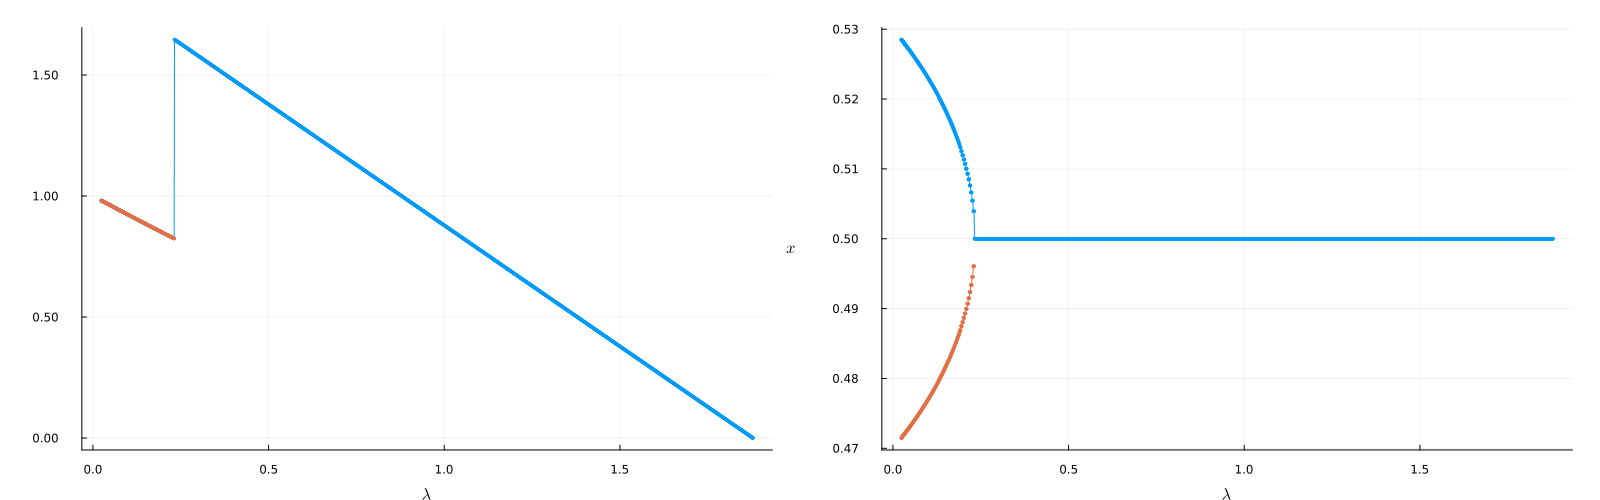

In [457]:
λs, μs = values(prob_NODE.reg_path)

λ_step = 1
idxs = 1:λ_step:length(λs)
λs, μs = λs[idxs], μs[idxs]

x_paths, a_paths = build_reg_paths(λs, μs, C=1e100)
plt_NODE_paths = plot_reg_paths(λs, x_paths, a_paths, size=(800, 250) .* 2)

In [ ]:
plot(plt_MDP_paths, plt_NODE_paths; layout=(1, 2), size=(1000, 700), title=["MDP" "" "NODE" ""])